In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
from scipy.linalg import cholesky, solve_triangular

from modmcmc import State, BlockMCMCSampler, LogDensityTerm, TargetDensity
from modmcmc.kernels import MarkovKernel, GaussMetropolisKernel, DiscretePCNKernel, mvn_logpdf
import modmcmc as mm
from Gaussian import Gaussian
from helper import get_col_hist_grid, plot_trace

In [2]:
rng = np.random.default_rng(532124)

# Set up linear Gaussian inverse problem and forward model emulator

In [13]:
# Linear Gaussian inverse problem

# Parameter and observation dimension
d = 2
n = 10

# Prior
m = rng.normal(size=d)
C_sqrt = rng.normal(size=(d,d))
C = C_sqrt @ C_sqrt.T
u = Gaussian(mean=m, cov=C, rng=rng)

# Linear forward model
G = rng.normal(size=(n,d))

# Noise covariance
Sig_sqrt = rng.normal(size=(n,n))
Sig = Sig_sqrt @ Sig_sqrt.T
noise = Gaussian(cov=Sig, rng=rng)

# Data
y = G @ u.sample() + noise.sample()

In [14]:
# Forward model emulator of the form f_star(u) = f(u) + e, e ~ N(r, Q)
q_scale = 0.2
r = 4*np.ones(n) # rng.normal(size=n)
Q_sqrt = q_scale * rng.normal(size=(n,n))
Q = Q_sqrt @ Q_sqrt.T
e = Gaussian(mean=r, cov=Q, rng=rng)

# Helper functions to compute closed-form EP and EUP distributions

In [15]:
def get_ep_rv(y, u, G, Sig, e):
    u_post = u.invert_affine_Gaussian(y, A=G, cov_noise=Sig, store="both")
    L_Sig = cholesky(Sig, lower=True)
    C1 = solve_triangular(L_Sig, G, lower=True)
    C2 = solve_triangular(L_Sig.T, C1, lower=False)    
    B = -u_post.cov @ C2.T    
    u_ep = e.convolve_with_Gaussian(A=B, b=u_post.mean, cov_new=u_post.cov)
    return u_ep

def get_eup_rv(y, u, G, Sig, e):
    u_eup = u.invert_affine_Gaussian(y, A=G, b=e.mean, cov_noise=Sig+e.cov)
    return u_eup

In [16]:
def direct_sample_ep(y, u, G, Sig, e, num_samp):
    samp = np.empty((num_samp, u.dim))
    for i in range(num_samp):
        samp[i,:] = u.invert_affine_Gaussian(y, A=G, b=e.sample(), cov_noise=Sig).sample()
    return samp

# Approximate Metropolis-within-Gibbs sampling for EP

In [17]:
Q_chol = cholesky(Q, lower=True)
ldens_surrogate = lambda state: e.log_p(state.primary["e"])
def ldens_post(state):
    fwd = G @ state.primary["u"] + state.primary["e"]
    return mvn_logpdf(y, mean=fwd, L=Q_chol) + u.log_p(state.primary["u"])

state = State(primary={"u": u.sample(), "e": e.sample()})
target = TargetDensity([LogDensityTerm("surrogate", ldens_surrogate), 
                        LogDensityTerm("post", ldens_post)])
ker_u = GaussMetropolisKernel(target, proposal_cov=0.1*u.cov, term_subset="post", 
                              block_vars="u", rng=rng)
ker_e = DiscretePCNKernel(target, mean_Gauss=e.mean, cov_Gauss=e.cov, cor_param=0.9, 
                          term_subset="surrogate", block_vars="e", rng=rng)
mwp = BlockMCMCSampler(target, initial_state=state, kernels=[ker_u, ker_e])

In [18]:
n_mcmc = 100000
mwp.sample(num_steps=n_mcmc)

In [19]:
mcmc_samp = np.empty((len(mwp.trace), u.dim))
for i in range(mcmc_samp.shape[0]):
    mcmc_samp[i,:] = mwp.trace[i].primary["u"]

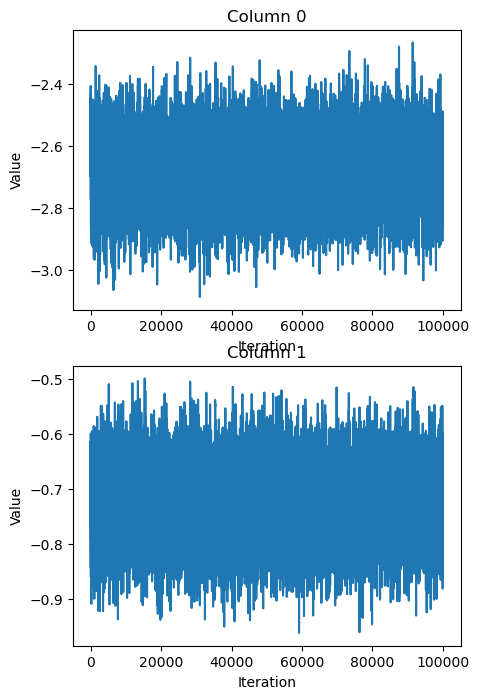

In [20]:
trace_plots = plot_trace(mcmc_samp, nrows=2)
plt.show()

# Compare distributions

In [21]:
u_post = u.invert_affine_Gaussian(y, A=G, cov_noise=Sig)
u_ep = get_ep_rv(y, u, G, Sig, e)
u_eup = get_eup_rv(y, u, G, Sig, e)

In [22]:
n_samp = 100000
samp_post = u_post.sample(n_samp)
samp_ep = u_ep.sample(n_samp)
samp_eup = u_eup.sample(n_samp)
# samp_ep2 = direct_sample_ep(y, u, G, Sig, e, n_samp)

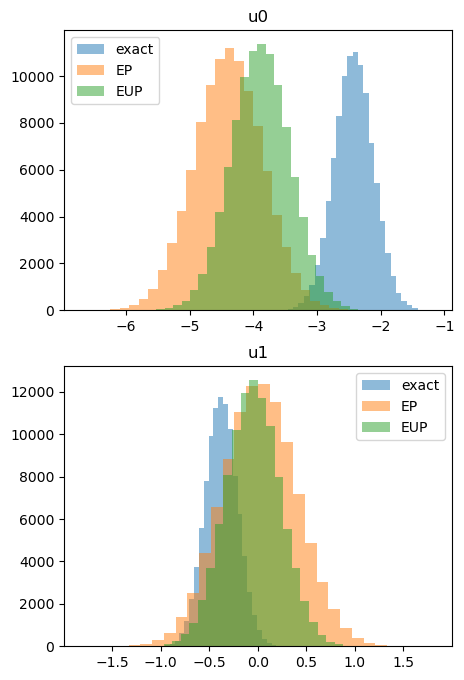

In [23]:
col_labs=[f"u{i}" for i in range(d)]
plot_labs = ["exact", "EP", "EUP"] #, "EP2"]

hist_plt = get_col_hist_grid(samp_post, samp_ep, samp_eup, bins=30, nrows=2, 
                             col_labs=col_labs, plot_labs=plot_labs)
plt.show()

# Compare exact EP vs MwG approximation

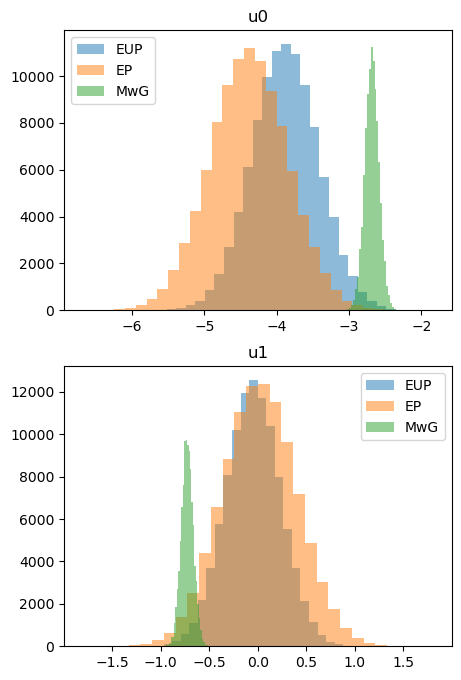

In [26]:
hist_plt_mwg = get_col_hist_grid(samp_eup, samp_ep, mcmc_samp, bins=30, nrows=2, 
                                 col_labs=col_labs, plot_labs=["EUP", "EP", "MwG"])
plt.show()